In [1]:
#!/Tsan/bin/python
# -*- coding: utf-8 -*-

In [86]:
# Libraries to use
from __future__ import division 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,time
import time

In [3]:
# Import My own library for factor testing
from SingleFactorTest import factorFilterFunctions as ff
from BackTestingEngine import backTestingEngine as bte
#from config import *

In [4]:
%matplotlib inline
%load_ext line_profiler

In [5]:
# make sure that matplotib and seaborn can show Chinese
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

In [6]:
path = ff.data_path

In [188]:
startTime =  datetime.strptime('20120101', '%Y%m%d')
endTime = datetime.strptime('20170228', '%Y%m%d')

In [189]:
year2012 = [datetime.strptime('20120101', '%Y%m%d'),datetime.strptime('20121231', '%Y%m%d')]

In [40]:
filenameIndex = 'LZ_CN_STKA_INDXQUOTE_CLOSE.h5' # 指数收盘价
filenameIndexAmount = 'LZ_CN_STKA_INDXQUOTE_AMOUNT.h5'   # 指数成交额

In [438]:
# 行业
filenameInduFlag = 'LZ_CN_STKA_INDU_ZX.h5'  # 行业标识

# 
filenameZXExplanation = 'LZ_GPA_TMP_INDU_ZX.csv'  # 行业解释字典

In [192]:
filenameCSIWeight = 'LZ_CN_STKA_INDEX_CSI500WEIGHT.h5' # 中证500权重
filenameHS300Weight = 'LZ_CN_STKA_INDEX_HS300WEIGHT.h5' # 沪深300权重 （benchmark）

In [363]:
# A股信息
filenameFshr = 'LZ_CN_STKA_VAL_FSHR.h5' # 流通股本
filenameFcap = 'LZ_CN_STKA_VAL_A_FCAP.h5' # 流通市值
filenamePrft = 'LZ_CN_STKA_CRD_NET_PRFT_FTTM.h5' # 净利润
filenameOprinc = 'LZ_CN_STKA_FIN_IND_QFA_OPRINC.h5' # 净收益
filenameEqy = 'LZ_CN_STKA_BAL_COMBO_TOTL_LIAB_SHRHLDR_EQY.h5' # 股东权益
filenameNetAsset = 'LZ_CN_STKA_VAL_NET_ASSET.h5' # 净资产
filenameClose = 'LZ_CN_STKA_QUOTE_TCLOSE.h5' # 收盘价

In [302]:
# wind 全A
filenameWindA = 'windA.csv'

In [441]:
#
hs300,csi500,windA= '000300.SH','000905.SH','881001'
indexList = [hs300,csi500,windA]

In [485]:
indexData = ff.readh5data(path,filenameIndex)
tradeAmount = ff.readh5data(path,filenameIndexAmount)

windAindex = pd.read_csv(path+filenameWindA,infer_datetime_format=True,parse_dates=[0],index_col=0).CLOSE
windAindex.name = windA
windAAmount = pd.read_csv(path+filenameWindA,infer_datetime_format=True,parse_dates=[0],index_col=0).AMOUNT
windAAmount.name = windA

indexData = pd.concat([windAindex,indexData],axis=1)
tradeAmount = pd.concat([windAAmount,tradeAmount],axis=1)

In [444]:
# 指数收益的相关性
coeff_matrix = indexData[indexList].loc[year2012[0]:year2012[1]].pct_change().corr(method='pearson').round(4)

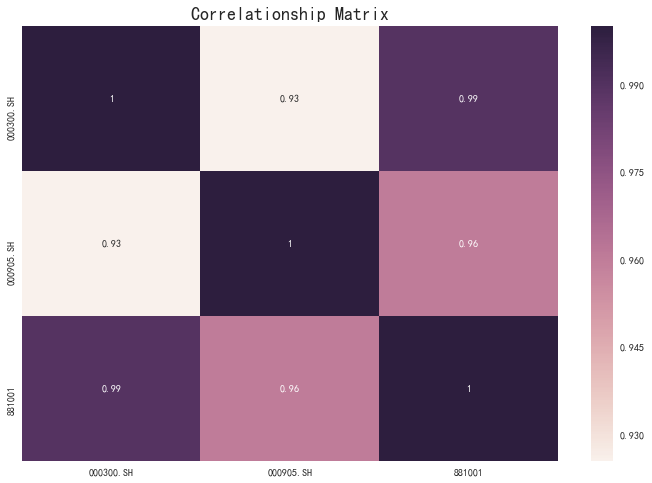

In [447]:
# visualization 
plt.figure(figsize=(12,8))
ax = plt.axes()
sns.heatmap(coeff_matrix ,ax=ax, annot=True)
ax.set_title('Correlationship Matrix',fontsize=18, fontweight='bold')
plt.show()

In [452]:
# 年化收益率
networth = indexData[indexList].loc[year2012[0]:year2012[1]] / indexData[indexList].loc[year2012[0]:year2012[1]].iloc[0]
(networth.iloc[-1]) ** (250 / networth.shape[0]) - 1

000300.SH    0.100477
000905.SH    0.026961
881001       0.066025
Name: 2012-12-31 00:00:00, dtype: float64

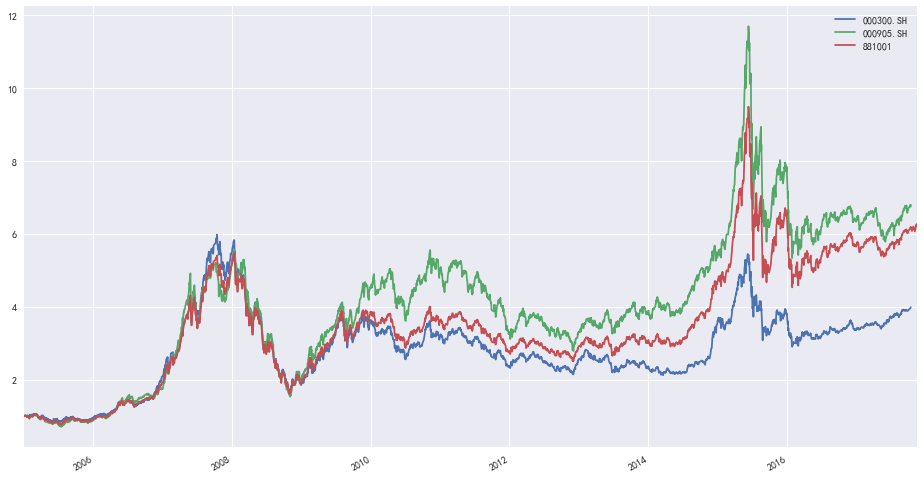

In [454]:
# 净值数据
(indexData[indexList] /indexData[indexList].iloc[0]).plot(figsize=(16,9))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

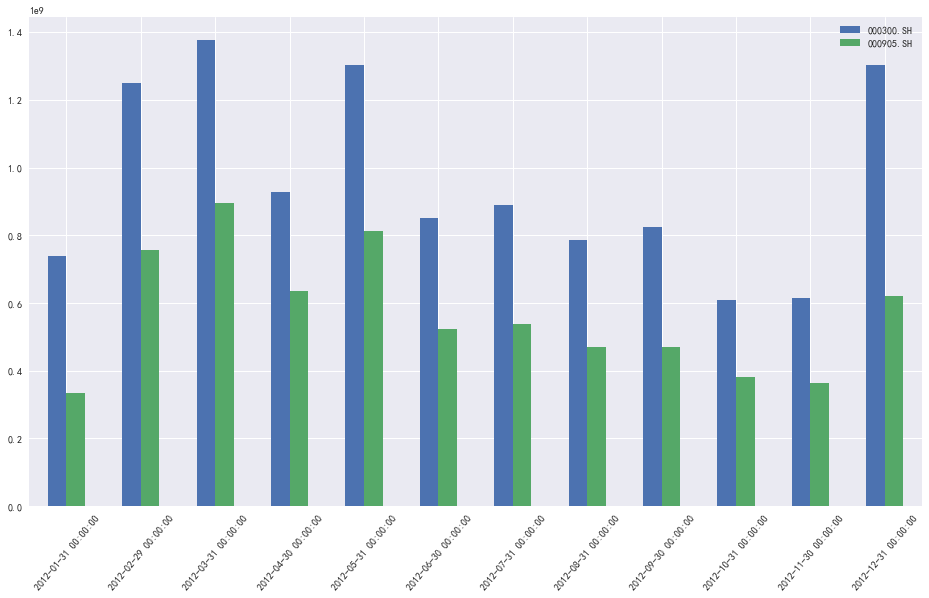

In [465]:
# 成交量的bar
tradeAmount[[hs300,csi500]].loc[year2012[0]:year2012[1]].resample('M').sum().plot(kind='bar',figsize=(16,9))
plt.xticks(rotation=50)

In [197]:
# 相关性
correlation = indexData[csi500].corr(benchmark)

In [198]:
# 股本结构
csimember = ff.readh5data(path,filenameCSIWeight).loc[year2012[0]:year2012[1]]
fshr = ff.readh5data(path,filenameFshr).loc[year2012[0]:year2012[1]]   # 总股本
csifshr = pd.DataFrame(index = fshr.index, columns = ['fshr'],dtype =float)
for date in csimember.index:
    memberList = csimember.loc[date].dropna().index.tolist()
    csifshr.loc[date] = fshr.loc[date][memberList].sum()
fshrRatio = csifshr.divide(fshr.sum(axis=1),axis=0).squeeze().mean()

In [528]:
ff.readh5data(path,filenameFshr).iloc[-2]['601318.SH']

1083266.4498000001

In [199]:
fshrRatio

0.13190875324538534

In [217]:
# 市值覆盖率 & 行业覆盖率
fcap = ff.readh5data(path,filenameFcap).loc[year2012[0]:year2012[1]]  # 流通市值
indu = ff.readh5data(path,filenameInduFlag ).loc[year2012[0]:year2012[1]]  # 行业
csifcap = pd.DataFrame(index = fcap.index, columns = ['fcap'],dtype =float)
indudf= pd.DataFrame(index = indu.index, columns = ['fcap'],dtype =float)
for date in csimember.index:
    memberList = csimember.loc[date].dropna().index.tolist()
    csifcap.loc[date] = fcap.loc[date][memberList].sum()
    indudf.loc[date] = indu.loc[date][memberList].drop_duplicates().shape[0]
fcapRatio = csifcap.divide(fcap.sum(axis=1),axis=0).squeeze().mean()
induRatio = (indudf/29).squeeze().mean()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

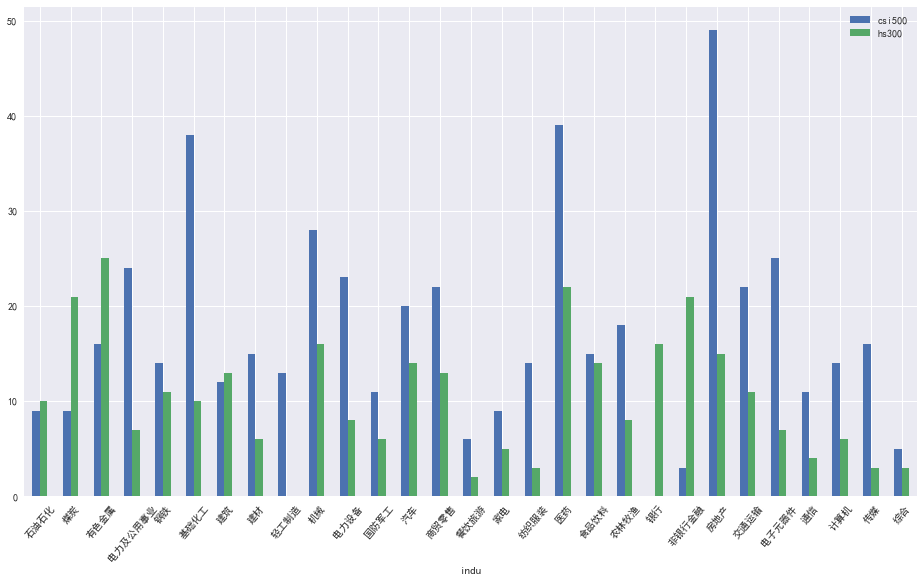

In [464]:
# 画出指数成分股的各行业分布
induExplanation = pd.read_csv(path+filenameZXExplanation,infer_datetime_format=True,parse_dates=[0],encoding='gb2312')
induExplanation.index = induExplanation.index.map(lambda x: x+1)
memberList = csimember.iloc[-1].dropna().index.tolist()
a = indu.iloc[-1][memberList].groupby(indu.iloc[-1][memberList]).count()
memberHs300 = hsmember.iloc[-1].dropna().index.tolist()
b = indu.iloc[-1][memberHs300].groupby(indu.iloc[-1][memberHs300]).count()
c = pd.concat([a,b,induExplanation],axis=1)
c.columns = ['csi500','hs300','indu']
c.index.name = 'industry'
c.set_index('indu',inplace= True)
c.plot(kind= 'bar',figsize=(16,9))
plt.xticks(rotation=50)

In [218]:
induRatio

0.9655172413793084

In [201]:
# 成分股数量、调整频率，调整幅度
adjNum , adjfrequency, adjRange = 500, 120, 100

In [202]:
# 成分股的流动性（日均成交金额、日均换手率、流动性指标）
tradeAmount = ff.readh5data(path,filenameIndexAmount).loc[year2012[0]:year2012[1]][csi500]
turnoverRatiodf = tradeAmount.divide(csifcap.squeeze(),axis=0)
liquidIndicator = np.abs(np.log(indexData[csi500]) - np.log(indexData[csi500].shift(1))).divide(turnoverRatiodf,axis=0)

dailyTradeAmount = tradeAmount.mean() # 日均成交金额
dailyTurnoverRatio = turnoverRatiodf.mean()  # 日均换手率
dailyLiquidIndicator = liquidIndicator.mean()   # 流动性指标

In [203]:
# 标准差 夏普比率
std = indexData[csi500].pct_change().std() * np.sqrt(250)
sharpe = ((indexData[csi500].iloc[-1] / indexData[csi500].iloc[0]) ** (250/ indexData[csi500].shape[0]) -1) / std 

In [204]:
# 盈利能力 ，平均每股
prft = ff.readh5data(path,filenamePrft).loc[year2012[0]:year2012[1]]  # 净利润
oprinc = ff.readh5data(path,filenameOprinc).loc[year2012[0]:year2012[1]]  # 净收益
eqy = ff.readh5data(path,filenameEqy).loc[year2012[0]:year2012[1]]  # 股东权益
csieps = pd.DataFrame(index = fcap.index, columns = ['eps'],dtype =float)
csiroe = pd.DataFrame(index = indu.index, columns = ['froe'],dtype =float)
for date in csimember.index:
    memberList = csimember.loc[date].dropna().index.tolist()
    csieps .loc[date] = oprinc.loc[date][memberList].sum() / fshr.loc[date][memberList].sum() 
    csiroe.loc[date] = prft.loc[date][memberList].sum() / eqy.loc[date][memberList].sum() 
csieps = csieps.squeeze().mean()
csiroe  = csiroe.squeeze().mean()

In [210]:
# 估值水平 pe pb 
hsmember = ff.readh5data(path,filenameHS300Weight).loc[year2012[0]:year2012[1]]  # 沪深300的成分股
netAsset = ff.readh5data(path,filenameNetAsset).loc[year2012[0]:year2012[1]]  # 净资产
peAbs = pd.DataFrame(index = fcap.index, columns = ['pe'],dtype =float)  # pe绝对值
peRel = pd.DataFrame(index = fcap.index, columns = ['pe'],dtype =float)  # pe相对值
pbAbs = pd.DataFrame(index = fcap.index, columns = ['pb'],dtype =float)  # pb绝对值
pbRel = pd.DataFrame(index = fcap.index, columns = ['pb'],dtype =float)  # pb相对值
for date in csimember.index:
    memberList = csimember.loc[date].dropna().index.tolist()
    hsmemberList = hsmember.loc[date].dropna().index.tolist()
    peAbs .loc[date] = fcap.loc[date][memberList].sum() / prft .loc[date][memberList].sum() 
    pbAbs.loc[date] = fcap.loc[date][memberList].sum() / netAsset.loc[date][memberList].sum() 
    peRel.loc[date] = peAbs .loc[date] / (fcap.loc[date][hsmemberList].sum() / prft .loc[date][hsmemberList].sum())
    pbRel.loc[date] = pbAbs .loc[date] / (fcap.loc[date][hsmemberList].sum() / netAsset .loc[date][hsmemberList].sum())
peAbs = peAbs.squeeze().mean()
peRel = peRel.squeeze().mean()
pbAbs = pbAbs.squeeze().mean()
pbRel = pbRel.squeeze().mean()

In [211]:
peAbs

0.018525681619818827

In [227]:
indexList = ['Cor','Structure','Fcap_Coverage','Indu_Coverage','Amount','Turnover','Liquidity','Std','Sharpe',
            'Eps','Roe','PeAbs','PeRel','PbAbs','PbRel']
data = [correlation,fshrRatio,fcapRatio,induRatio,dailyTradeAmount,dailyTurnoverRatio,dailyLiquidIndicator,
       std,sharpe,csieps,csiroe,peAbs,peRel,pbAbs,pbRel]
columnNames = ['2012']

In [228]:
resultdf = pd.DataFrame(index =indexList,data=data,columns = columnNames)
resultdf.round(4)

,2012
Cor,9.391000e-01
Structure,1.319000e-01
Fcap_Coverage,1.336000e-01
Indu_Coverage,9.655000e-01
Amount,2.797644e+07
Turnover,1.210000e-01
Liquidity,1.027000e-01
Std,2.436000e-01
Sharpe,1.107000e-01
Eps,7.848227e+02


In [226]:
resultdf.iloc[4]

2012    500.0
Name: Num, dtype: float64

In [286]:
benchmarkdf = getIndexIndicators(hs300,filenameHS300Weight,hs300,filenameHS300Weight,year2012,'2012')
benchmarkdf.iloc[:4] = 1

In [269]:
# 计算得分
def calFinalScore(x,bench,intervalNum = 6):
    bench = np.linspace(0,bench,intervalNum)
    for i in xrange(intervalNum-1):
        if  bench[i]<= x < bench[i+1]:
            finalScore = i+1
            continue
    if x >= bench[i+1]: # 若超过上界则得分为0
        finalScore = 0
    return finalScore

In [278]:
calFinalScore(resultdf.iloc[7].values,1)

2

In [288]:
weightList = [0.06,0.06,0.06,0.06,0.05,0.05,0.08,0.1,0.16,0.06,0.1,0.04,0.04,0.04,0.04]

In [285]:
rankList = []
for index in resultdf.index:
    rankList.append(calFinalScore(resultdf.loc[index].values,benchmarkdf.loc[index].values))

In [287]:
rankList

[5, 1, 1, 5, 3, 0, 3, 0, 2, 2, 0, 0, 0, 0, 0]

In [468]:
def calTotalScore(resultdf,benchmarkdf,weightList):
    rankList = []
    for index in resultdf.index:
        rankList.append(calFinalScore(resultdf.loc[index].values,benchmarkdf.loc[index].values))
    totalScore = (np.array(rankList) * np.array([weightList])).sum()
    return totalScore

In [472]:
calTotalScore(resultdf,windAindicators,weightList)

1.2599999999999998

In [297]:
totalScore = (np.array(rankList) * np.array([weightList])).sum()
totalScore

1.5499999999999998

In [252]:
np.linspace(0,benchmarkdf.iloc[6].values,6)

array([ 0.     ,  0.04848,  0.09696,  0.14544,  0.19392,  0.2424 ])

In [378]:
getIndexIndicators(csi500,filenameCSIWeight,windA,year2012,'2012',indexData,tradeAmount)

,2012
Cor,9.635000e-01
Structure,1.319000e-01
Fcap_Coverage,1.336000e-01
Indu_Coverage,9.655000e-01
Amount,2.797644e+07
Turnover,1.210000e-01
Liquidity,1.027000e-01
Std,2.436000e-01
Sharpe,1.107000e-01
Eps,7.848227e+02


In [470]:
windAindicators = getIndexIndicators(windA,filenameClose,windA,year2012,'2012',indexData,tradeAmount)

In [376]:
def getIndexIndicators(csi500,filenameCSIWeight,benchmark,timeperiod,year,indexData,tradeAmount):
    
    # 指数
    
    indexData = indexData.loc[timeperiod[0]:timeperiod[1]]
    correlation = indexData[csi500].corr(indexData[benchmark])
    
    # 股本结构
    csimember = ff.readh5data(path,filenameCSIWeight).loc[timeperiod[0]:timeperiod[1]]
    fshr = ff.readh5data(path,filenameFshr).loc[timeperiod[0]:timeperiod[1]]   # 总股本
    csifshr = pd.DataFrame(index = fshr.index, columns = ['fshr'],dtype =float)
    
    # 市值覆盖率 & 行业覆盖率
    fcap = ff.readh5data(path,filenameFcap).loc[timeperiod[0]:timeperiod[1]]  # 流通市值
    indu = ff.readh5data(path,filenameInduFlag ).loc[timeperiod[0]:timeperiod[1]]  # 行业
    csifcap = pd.DataFrame(index = fcap.index, columns = ['fcap'],dtype =float)
    indudf= pd.DataFrame(index = indu.index, columns = ['fcap'],dtype =float)
    
    
    
    # 标准差 夏普比率
    std = indexData[csi500].pct_change().std() * np.sqrt(250)
    sharpe = ((indexData[csi500].iloc[-1] / indexData[csi500].iloc[0]) ** (250/ indexData[csi500].shape[0]) -1) / std
    
    # 盈利能力 ，平均每股
    prft = ff.readh5data(path,filenamePrft).loc[timeperiod[0]:timeperiod[1]]  # 净利润
    oprinc = ff.readh5data(path,filenameOprinc).loc[timeperiod[0]:timeperiod[1]]  # 净收益
    eqy = ff.readh5data(path,filenameEqy).loc[timeperiod[0]:timeperiod[1]]  # 股东权益
    csieps = pd.DataFrame(index = fcap.index, columns = ['eps'],dtype =float)
    csiroe = pd.DataFrame(index = indu.index, columns = ['froe'],dtype =float)
    
    # 估值水平 pe pb 
    windAmember = ff.readh5data(path,filenameClose).loc[timeperiod[0]:timeperiod[1]]  # 沪深300的成分股
    netAsset = ff.readh5data(path,filenameNetAsset).loc[timeperiod[0]:timeperiod[1]]  # 净资产
    peAbs = pd.DataFrame(index = fcap.index, columns = ['pe'],dtype =float)  # pe绝对值
    peRel = pd.DataFrame(index = fcap.index, columns = ['pe'],dtype =float)  # pe相对值
    pbAbs = pd.DataFrame(index = fcap.index, columns = ['pb'],dtype =float)  # pb绝对值
    pbRel = pd.DataFrame(index = fcap.index, columns = ['pb'],dtype =float)  # pb相对值
    
    # 循环计算
    for date in csimember.index:
        memberList = csimember.loc[date].dropna().index.tolist()
        csifshr.loc[date] = fshr.loc[date][memberList].sum()
        csifcap.loc[date] = fcap.loc[date][memberList].sum()
        indudf.loc[date] = indu.loc[date][memberList].drop_duplicates().shape[0]
        csieps .loc[date] = oprinc.loc[date][memberList].sum() / fshr.loc[date][memberList].sum() 
        csiroe.loc[date] = prft.loc[date][memberList].sum() / eqy.loc[date][memberList].sum()
        hsmemberList = windAmember.loc[date].dropna().index.tolist()
        peAbs .loc[date] = fcap.loc[date][memberList].sum() / prft .loc[date][memberList].sum() 
        pbAbs.loc[date] = fcap.loc[date][memberList].sum() / netAsset.loc[date][memberList].sum() 
        peRel.loc[date] = peAbs .loc[date] / (fcap.loc[date][hsmemberList].sum() / prft .loc[date][hsmemberList].sum())
        pbRel.loc[date] = pbAbs .loc[date] / (fcap.loc[date][hsmemberList].sum() / netAsset .loc[date][hsmemberList].sum())
        
    fshrRatio = csifshr.divide(fshr.sum(axis=1),axis=0).squeeze().mean()
    fcapRatio = csifcap.divide(fcap.sum(axis=1),axis=0).squeeze().mean()
    induRatio = (indudf/29).squeeze().mean()
    csieps = csieps.squeeze().mean()
    csiroe  = csiroe.squeeze().mean()
    peAbs = peAbs.squeeze().mean()
    peRel = peRel.squeeze().mean()
    pbAbs = pbAbs.squeeze().mean()
    pbRel = pbRel.squeeze().mean()
    
    # 成分股的流动性（日均成交金额、日均换手率、流动性指标）
    tradeAmount = tradeAmount.loc[timeperiod[0]:timeperiod[1]][csi500]
    turnoverRatiodf = tradeAmount.divide(csifcap.squeeze(),axis=0)
    liquidIndicator = np.abs(np.log(indexData[csi500]) - np.log(indexData[csi500].shift(1))).divide(turnoverRatiodf,axis=0)

    dailyTradeAmount = tradeAmount.mean() # 日均成交金额
    dailyTurnoverRatio = turnoverRatiodf.mean()  # 日均换手率
    dailyLiquidIndicator = liquidIndicator.mean()   # 流动性指标
    
    # 合成 dataframe
    indexList = ['Cor','Structure','Fcap_Coverage','Indu_Coverage','Amount','Turnover','Liquidity','Std','Sharpe',
            'Eps','Roe','PeAbs','PeRel','PbAbs','PbRel']
    data = [correlation,fshrRatio,fcapRatio,induRatio,dailyTradeAmount,dailyTurnoverRatio,dailyLiquidIndicator,
           std,sharpe,csieps,csiroe,peAbs,peRel,pbAbs,pbRel]
    columnNames = [year]
    resultdf = pd.DataFrame(index =indexList,data=data,columns = columnNames)
    return resultdf.round(4)

In [491]:
a = indexData.loc[year2012[0]:year2012[1]].pct_change()
b = a[[hs300,csi500]].sub(a[windA],axis=0)

In [504]:
c =1 - (b[b>0].isnull().sum() / b.shape[0])

In [507]:
c.name = '2012'
c

000300.SH    0.481481
000905.SH    0.502058
Name: 2012, dtype: float64

In [520]:
# 计算胜率
def calWinratio(indexData,indexlabel,benchmark,year,timeperiod):
    index = indexData.loc[timeperiod[0]:timeperiod[1]].pct_change()
    ret = index[indexlabel].sub(index[benchmark],axis=0)
    winratio=1 - (ret[ret>0].isnull().sum() / ret.shape[0])
    winratio.name = year
    return winratio

In [521]:
calWinratio(indexData,[hs300,csi500],windA,'2012',year2012)

000300.SH    0.481481
000905.SH    0.502058
Name: 2012, dtype: float64

In [522]:
timedict = {'2014':[datetime.strptime('20140101', '%Y%m%d'), datetime.strptime('20141231', '%Y%m%d')],
            '2015': [datetime.strptime('20150101', '%Y%m%d'), datetime.strptime('20151231', '%Y%m%d')],
            '2016': [datetime.strptime('20160101', '%Y%m%d'), datetime.strptime('20161231', '%Y%m%d')],}

In [524]:
b = pd.DataFrame()
for i,j in timedict.iteritems():
    a = calWinratio(indexData,[hs300,csi500],windA,i,j)
    b = pd.concat([b,a],axis=1)
b

,2015,2014,2016
000300.SH,0.389344,0.408163,0.426230
000905.SH,0.536885,0.510204,0.471311


In [564]:
exchi_step = 4
batch_size = 5
total_series_length = 50000
echo_step = 3
state_size = 4
x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
y = np.roll(x, echo_step)
y[0:echo_step] = 0

x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
y = y.reshape((batch_size, -1))

x

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 1, 0]], dtype=int64)

In [566]:
np.zeros((batch_size, state_size))

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [568]:
x = np.array(np.random.choice(2, 10, p=[0.5, 0.5]))
y = np.roll(x, 2)
x

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1], dtype=int64)

In [567]:
y

array([[0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 0, 1, ..., 0, 1, 1]], dtype=int64)

In [570]:
y = y.reshape((batch_size, -1))


array([1, 0, 0, 0, 0], dtype=int64)

In [13]:
path = ff.data_path


# 文件名
filenameIndex = 'LZ_CN_STKA_INDXQUOTE_CLOSE.h5'  # 指数收盘价
filenameIndexAmount = 'LZ_CN_STKA_INDXQUOTE_AMOUNT.h5'   # 指数成交额

# 行业
filenameInduFlag = 'LZ_CN_STKA_INDU_ZX.h5'  # 行业标识
filenameZXExplanation = 'LZ_GPA_TMP_INDU_ZX.csv'  # 行业解释字典

filenameCSIWeight = 'LZ_CN_STKA_INDEX_CSI500WEIGHT.h5'  # 中证500权重
filenameHS300Weight = 'LZ_CN_STKA_INDEX_HS300WEIGHT.h5'  # 沪深300权重 （benchmark）

# A股信息
filenameFshr = 'LZ_CN_STKA_VAL_FSHR.h5'  # 流通股本
filenameFcap = 'LZ_CN_STKA_VAL_A_FCAP.h5'  # 流通市值
filenamePrft = 'LZ_CN_STKA_CRD_NET_PRFT_FTTM.h5'  # 净利润
filenameOprinc = 'LZ_CN_STKA_FIN_IND_QFA_OPRINC.h5'  # 净收益
filenameEqy = 'LZ_CN_STKA_BAL_COMBO_TOTL_LIAB_SHRHLDR_EQY.h5'  # 股东权益
filenameNetAsset = 'LZ_CN_STKA_VAL_NET_ASSET.h5'  # 净资产
filenameClose = 'LZ_CN_STKA_QUOTE_TCLOSE.h5'  # 收盘价


#
filenameEps = 'LZ_CN_STKA_PRF_PARENT_S_FA_EPS_BASIC.h5'  # eps
filenameRoe = 'LZ_CN_STKA_FIN_IND_ROE.h5'  # roe
filenamePb = 'LZ_CN_STKA_VAL_PB.h5'  # pb
filenamePe = 'LZ_CN_STKA_VAL_PE.h5'  #  pe


# wind 全A
filenameWindA = 'WindA.csv'

In [15]:
year2012 = [datetime.strptime('20120101', '%Y%m%d'), datetime.strptime('20121231', '%Y%m%d')]
hs300, csi500, windA = '000300.SH', '000905.SH', '881001'
indexList = [hs300, csi500, windA]
weightList = [0.06, 0.06, 0.06, 0.06, 0.05, 0.05, 0.08, 0.1, 0.16, 0.06, 0.1, 0.04, 0.04, 0.04, 0.04]  # 得分权重

timedict = {'2014': [datetime.strptime('20140101', '%Y%m%d'), datetime.strptime('20141231', '%Y%m%d')],
            '2015': [datetime.strptime('20150101', '%Y%m%d'), datetime.strptime('20151231', '%Y%m%d')],
            '2016': [datetime.strptime('20160101', '%Y%m%d'), datetime.strptime('20161231', '%Y%m%d')]}

In [16]:
# 数据预处理
indexData = ff.readh5data(path, filenameIndex)
tradeAmount = ff.readh5data(path, filenameIndexAmount)

windAindex = pd.read_csv(path+filenameWindA, infer_datetime_format=True, parse_dates=[0], index_col=0).CLOSE
windAindex.name = windA
windAAmount = pd.read_csv(path+filenameWindA, infer_datetime_format=True, parse_dates=[0], index_col=0).AMOUNT
windAAmount.name = windA

indexData = pd.concat([windAindex, indexData], axis=1)
tradeAmount = pd.concat([windAAmount, tradeAmount], axis=1)

csimember1 = ff.readh5data(path, filenameCSIWeight)
fshr1 = ff.readh5data(path, filenameFshr)   # 总股本
fcap1 = ff.readh5data(path, filenameFcap)   # 市值
indu1 = ff.readh5data(path, filenameInduFlag)  # 行业
prft1 = ff.readh5data(path, filenamePrft)  # 净利润
oprinc1 = ff.readh5data(path, filenameOprinc)  # 净收益
eqy1 = ff.readh5data(path, filenameEqy)   # 股东权益
windAmember1 = ff.readh5data(path, filenameClose)  # windA
netAsset1 = ff.readh5data(path, filenameNetAsset)

In [57]:
# 指标后去函数
def getIndexIndicators(csi500, memberList, benchmark, timeperiod, year, indexData, tradeAmount):
    """参数依次为：要计算的指数代码（str）,要计算的指数的权重文件名，基准代码，时间，时间名，指数数据（DataFrame），
    成交量数据（dataframe）, 可参见调用形式"""

    indexData = indexData.loc[timeperiod[0]:timeperiod[1]]
    correlation = indexData[csi500].corr(indexData[benchmark])

    # 股本结构
    #csimember = csimember1.loc[timeperiod[0]:timeperiod[1]]
    fshr = 10000 * fshr1.loc[timeperiod[0]:timeperiod[1]]  # 总股本
    csifshr = pd.DataFrame(index=fshr.index, columns=['fshr'], dtype=float)

    # 市值覆盖率 & 行业覆盖率
    fcap = 10000 * fcap1.loc[timeperiod[0]:timeperiod[1]]  # 流通市值
    indu = indu1.loc[timeperiod[0]:timeperiod[1]]  # 行业
    csifcap = pd.DataFrame(index=fcap.index, columns=['fcap'], dtype=float)
    indudf = pd.DataFrame(index=indu.index, columns=['fcap'], dtype=float)

    # 标准差 夏普比率
    std = indexData[csi500].pct_change().std() * np.sqrt(250)
    sharpe = ((indexData[csi500].iloc[-1] / indexData[csi500].iloc[0]) ** (250 / indexData[csi500].shape[0]) - 1) / std

    # 盈利能力 ，平均每股
    #eps = ff.readh5data(path,filenameEps).loc[timeperiod[0]:timeperiod[1]]
    #roe = ff.readh5data(path, filenameRoe).loc[timeperiod[0]:timeperiod[1]]
    #pb = ff.readh5data(path, filenamePb).loc[timeperiod[0]:timeperiod[1]]
    #pe = ff.readh5data(path, filenamePe).loc[timeperiod[0]:timeperiod[1]]
    prft = prft1.loc[timeperiod[0]:timeperiod[1]]  # 净利润
    oprinc = oprinc1.loc[timeperiod[0]:timeperiod[1]]  # 净收益

    eqy =eqy1.loc[timeperiod[0]:timeperiod[1]]  # 股东权益
    csieps = pd.DataFrame(index=fcap.index, columns=['eps'], dtype=float)
    csiroe = pd.DataFrame(index=indu.index, columns=['froe'], dtype=float)

    # 估值水平 pe pb
    windAmember = windAmember1.loc[timeperiod[0]:timeperiod[1]]  # 沪深300的成分股
    netAsset = netAsset1 .loc[timeperiod[0]:timeperiod[1]]  # 净资产
    peAbs = pd.DataFrame(index=fcap.index, columns=['pe'], dtype=float)  # pe绝对值
    peRel = pd.DataFrame(index=fcap.index, columns=['pe'], dtype=float)  # pe相对值
    pbAbs = pd.DataFrame(index=fcap.index, columns=['pb'], dtype=float)  # pb绝对值
    pbRel = pd.DataFrame(index=fcap.index, columns=['pb'], dtype=float)  # pb相对值

    # 循环计算
    for date in indexData.index:
        csifshr.loc[date] = fshr.loc[date][memberList].sum()
        csifcap.loc[date] = fcap.loc[date][memberList].sum()
        indudf.loc[date] = indu.loc[date][memberList].drop_duplicates().shape[0]
        csieps.loc[date] = oprinc.loc[date][memberList].sum() / fshr.loc[date][memberList].sum()
        csiroe.loc[date] = prft.loc[date][memberList].sum() / eqy.loc[date][memberList].sum()
        hsmemberList = windAmember.loc[date].dropna().index.tolist()
        try:
            peAbs.loc[date] = fcap.loc[date][memberList].sum() / prft.loc[date][memberList].sum()
        except ZeroDivisionError:
            peAbs.loc[date] = np.NaN
        pbAbs.loc[date] = fcap.loc[date][memberList].sum() / netAsset.loc[date][memberList].sum()
        peRel.loc[date] = peAbs.loc[date] / (fcap.loc[date][hsmemberList].sum() / prft.loc[date][hsmemberList].sum())
        pbRel.loc[date] = pbAbs.loc[date] / (
        fcap.loc[date][hsmemberList].sum() / netAsset.loc[date][hsmemberList].sum())

        # eps = ff.readh5data(path,filenameEps).loc[timeperiod[0]:timeperiod[1]]
        #roe = ff.readh5data(path, filenameRoe).loc[timeperiod[0]:timeperiod[1]]
        #pb = ff.readh5data(path, filenamePb).loc[timeperiod[0]:timeperiod[1]]
        #pe = ff.readh5data(path, filenamePe).loc[timeperiod[0]:timeperiod[1]]

    fshrRatio = csifshr.divide(fshr.sum(axis=1), axis=0).squeeze().mean()
    fcapRatio = csifcap.divide(fcap.sum(axis=1), axis=0).squeeze().mean()
    induRatio = (indudf / 29).squeeze().mean()
    csieps = csieps.squeeze().mean()
    csiroe = csiroe.squeeze().mean()
    peAbs = peAbs.squeeze().mean()
    peRel = peRel.squeeze().mean()
    pbAbs = pbAbs.squeeze().mean()
    pbRel = pbRel.squeeze().mean()

    # 成分股的流动性（日均成交金额、日均换手率、流动性指标）
    tradeAmount = tradeAmount.loc[timeperiod[0]:timeperiod[1]][csi500]
    turnoverRatiodf = tradeAmount.divide(csifcap.squeeze(), axis=0)
    liquidIndicator = np.abs(np.log(indexData[csi500]) - np.log(indexData[csi500].shift(1))).divide(turnoverRatiodf,
                                                                                                    axis=0)

    dailyTradeAmount = tradeAmount.mean()  # 日均成交金额
    dailyTurnoverRatio = turnoverRatiodf.mean()  # 日均换手率
    dailyLiquidIndicator = liquidIndicator.mean()  # 流动性指标

    # 合成 dataframe
    indexList = ['Cor', 'Structure', 'Fcap_Coverage', 'Indu_Coverage', 'Amount', 'Turnover', 'Liquidity', 'Std',
                 'Sharpe',
                 'Eps', 'Roe', 'PeAbs', 'PeRel', 'PbAbs', 'PbRel']
    data = [correlation, fshrRatio, fcapRatio, induRatio, dailyTradeAmount, dailyTurnoverRatio, dailyLiquidIndicator,
            std, sharpe, csieps, csiroe, peAbs, peRel, pbAbs, pbRel]
    columnNames = [year]
    resultdf = pd.DataFrame(index=indexList, data=data, columns=columnNames)
    return resultdf.round(4)

In [25]:
# 计算得分
def calFinalScore(x,bench,intervalNum = 6):
    bench = np.linspace(0, bench, intervalNum)
    finalScore = 0
    for i in xrange(intervalNum-1):
        if bench[i] <= x < bench[i+1]:
            finalScore = i+1
            break
    return finalScore

# 计算总得分
def calTotalScore(resultdf,benchmarkdf,weightList):
    rankList = []
    for index in resultdf.index:
        rankList.append(calFinalScore(resultdf.loc[index].values, benchmarkdf.loc[index].values))
    totalScore = (np.array(rankList) * np.array([weightList])).sum()
    return totalScore

# 计算胜率
def calWinratio(indexData,indexlabel,benchmark,year,timeperiod):
    index = indexData.loc[timeperiod[0]:timeperiod[1]].pct_change()
    ret = index[indexlabel].sub(index[benchmark], axis=0)
    winratio=1 - (ret[ret>0].isnull().sum() / ret.shape[0])
    winratio.name = year
    return winratio

In [30]:
startTime =  datetime.strptime('20150101', '%Y%m%d')
endTime = datetime.strptime('20170228', '%Y%m%d')
indexData = indexData.loc[startTime:endTime]

In [31]:
endOfMonthList = sorted(list(set(indexData  .iloc[indexData  .resample('M').size().cumsum().sub(1)].index)))
endOfMonthList

[Timestamp('2015-01-30 00:00:00'),
 Timestamp('2015-02-27 00:00:00'),
 Timestamp('2015-03-31 00:00:00'),
 Timestamp('2015-04-30 00:00:00'),
 Timestamp('2015-05-29 00:00:00'),
 Timestamp('2015-06-30 00:00:00'),
 Timestamp('2015-07-31 00:00:00'),
 Timestamp('2015-08-31 00:00:00'),
 Timestamp('2015-09-30 00:00:00'),
 Timestamp('2015-10-30 00:00:00'),
 Timestamp('2015-11-30 00:00:00'),
 Timestamp('2015-12-31 00:00:00'),
 Timestamp('2016-01-29 00:00:00'),
 Timestamp('2016-02-29 00:00:00'),
 Timestamp('2016-03-31 00:00:00'),
 Timestamp('2016-04-29 00:00:00'),
 Timestamp('2016-05-31 00:00:00'),
 Timestamp('2016-06-30 00:00:00'),
 Timestamp('2016-07-29 00:00:00'),
 Timestamp('2016-08-31 00:00:00'),
 Timestamp('2016-09-30 00:00:00'),
 Timestamp('2016-10-31 00:00:00'),
 Timestamp('2016-11-30 00:00:00'),
 Timestamp('2016-12-30 00:00:00'),
 Timestamp('2017-01-26 00:00:00'),
 Timestamp('2017-02-28 00:00:00')]

In [46]:
indexTotal = ff.readh5data(path,filenameIndex)

In [143]:
# 表头
indulabelList = map(lambda x : 'CI00500' + str(x) + '.' + 'WI' if x < 10 else 'CI0050' + str(x) + '.' + 'WI',range(1,30))

In [144]:
induRankdf = pd.DataFrame(index = endOfMonthList, columns = indulabelList, dtype= float)

In [146]:
start =time.time()
for date in endOfMonthList[1:]:
    scoreList = []
    previousdate = endOfMonthList[endOfMonthList.index(date) -1]
    induthatday = indu1.loc[date]
    for indu in xrange(1,30):
        indumember = induthatday[induthatday==indu].index.tolist()
        indexname = 'CI00500' + str(indu) + '.' + 'WI' if indu < 10 else 'CI0050' + str(indu) + '.' + 'WI'
        print date
        print indu
        print indumember.__len__()
        windAmember= windAmember1.loc[date].dropna().index.tolist()
        indicators = getIndexIndicators(indexname, indumember, windA, [previousdate,date], '2015', indexData, tradeAmount)
        windAIndicators = getIndexIndicators(windA, windAmember, windA, [previousdate,date], '2015', indexData, tradeAmount)
        score = calTotalScore(indicators, windAIndicators, weightList)
        scoreList.append(score)
    induRankdf.loc[date] = scoreList
print '%s seconds elapsed' % (time.time() - start)

2015-02-27 00:00:00
1
47
2015-02-27 00:00:00
2
40
2015-02-27 00:00:00
3
94
2015-02-27 00:00:00
4
112
2015-02-27 00:00:00
5
60
2015-02-27 00:00:00
6
211
2015-02-27 00:00:00
7
73
2015-02-27 00:00:00
8
80
2015-02-27 00:00:00
9
64
2015-02-27 00:00:00
10
237
2015-02-27 00:00:00
11
128
2015-02-27 00:00:00
12
39


c:\python27\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in less_equal


2015-02-27 00:00:00
13
120
2015-02-27 00:00:00
14
94
2015-02-27 00:00:00
15
31
2015-02-27 00:00:00
16
55
2015-02-27 00:00:00
17
81
2015-02-27 00:00:00
18
196
2015-02-27 00:00:00
19
72
2015-02-27 00:00:00
20
82
2015-02-27 00:00:00
21
16
2015-02-27 00:00:00
22
30
2015-02-27 00:00:00
23
146
2015-02-27 00:00:00
24
91
2015-02-27 00:00:00
25
156
2015-02-27 00:00:00
26
81
2015-02-27 00:00:00
27
116
2015-02-27 00:00:00
28
63
2015-02-27 00:00:00
29
35
2015-03-31 00:00:00
1
47
2015-03-31 00:00:00
2
40
2015-03-31 00:00:00
3
94
2015-03-31 00:00:00
4
113
2015-03-31 00:00:00
5
61
2015-03-31 00:00:00
6
211
2015-03-31 00:00:00
7
73
2015-03-31 00:00:00
8
80
2015-03-31 00:00:00
9
65
2015-03-31 00:00:00
10
241
2015-03-31 00:00:00
11
130
2015-03-31 00:00:00
12
39
2015-03-31 00:00:00
13
121
2015-03-31 00:00:00
14
94
2015-03-31 00:00:00
15
30
2015-03-31 00:00:00
16
55
2015-03-31 00:00:00
17
81
2015-03-31 00:00:00
18
200
2015-03-31 00:00:00
19
73
2015-03-31 00:00:00
20
82
2015-03-31 00:00:00
21
16
2015-03-31

In [147]:
induRankdf

,CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,CI005010.WI,...,CI005020.WI,CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI
2015-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-27,1.40,1.30,1.18,0.90,1.60,1.20,1.28,2.02,1.60,1.24,...,1.78,1.30,1.30,1.16,1.54,1.16,0.86,0.70,1.06,0.94
2015-03-31,1.82,1.68,1.68,1.06,1.68,1.20,0.88,1.38,0.64,0.76,...,0.64,1.58,1.04,1.84,1.56,1.76,2.00,0.76,1.66,1.52
2015-04-30,1.12,1.70,1.62,0.58,1.84,1.24,0.78,1.52,1.28,0.70,...,1.12,1.84,1.00,1.54,1.60,1.08,1.06,1.24,0.88,2.02
2015-05-29,1.38,1.14,1.36,1.06,1.70,0.70,0.88,0.64,0.70,0.64,...,1.00,1.74,0.66,1.40,0.98,0.70,1.06,0.58,0.82,0.98
2015-06-30,1.72,1.14,0.88,0.58,0.98,0.70,0.88,0.64,0.70,0.70,...,0.96,1.74,1.48,1.42,0.82,1.10,0.96,0.64,0.82,0.94
2015-07-31,1.80,1.14,0.88,0.98,0.98,1.10,0.88,0.64,0.70,0.70,...,0.96,1.50,1.80,0.92,0.82,1.10,0.96,0.64,1.22,0.86
2015-08-31,1.72,1.14,0.88,0.78,0.98,1.16,0.88,0.64,0.70,0.70,...,0.96,1.72,1.88,0.98,0.82,1.10,0.96,0.64,0.88,0.88
2015-09-30,1.50,1.58,1.04,0.58,1.32,0.76,1.28,0.70,1.20,0.76,...,1.04,1.08,1.64,1.12,0.76,0.76,0.86,0.64,0.82,0.90
2015-10-30,1.98,1.26,0.64,1.22,1.86,0.76,2.08,1.34,0.70,1.56,...,0.70,1.38,1.64,1.92,1.24,0.76,0.96,1.10,0.88,0.90


In [148]:
induRankdf.columns = indulabelList
induRankdf.head()

,CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,CI005010.WI,...,CI005020.WI,CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI
2015-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-27,1.40,1.30,1.18,0.90,1.60,1.20,1.28,2.02,1.60,1.24,...,1.78,1.30,1.30,1.16,1.54,1.16,0.86,0.70,1.06,0.94
2015-03-31,1.82,1.68,1.68,1.06,1.68,1.20,0.88,1.38,0.64,0.76,...,0.64,1.58,1.04,1.84,1.56,1.76,2.00,0.76,1.66,1.52
2015-04-30,1.12,1.70,1.62,0.58,1.84,1.24,0.78,1.52,1.28,0.70,...,1.12,1.84,1.00,1.54,1.60,1.08,1.06,1.24,0.88,2.02
2015-05-29,1.38,1.14,1.36,1.06,1.70,0.70,0.88,0.64,0.70,0.64,...,1.00,1.74,0.66,1.40,0.98,0.70,1.06,0.58,0.82,0.98


In [149]:
induNetworth = indexData[indulabelList].loc[induRankdf.index[:]]
induRet = (induNetworth / induNetworth.iloc[0]).pct_change().iloc[1:]

In [150]:
induRet.head()

,CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,CI005010.WI,...,CI005020.WI,CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI
2015-02-27,0.041497,0.015562,0.031411,0.030968,0.055541,0.066889,0.106126,0.041333,0.062707,0.043462,...,0.043020,-0.008933,0.069140,0.033870,0.049324,0.089147,0.157053,0.207011,0.194148,0.081717
2015-03-31,0.112936,0.154862,0.173167,0.153938,0.198551,0.204556,0.253939,0.221523,0.261332,0.252360,...,0.233877,0.096588,0.105190,0.213642,0.212574,0.203858,0.240552,0.335191,0.172248,0.147388
2015-04-30,0.237040,0.204015,0.187408,0.220816,0.208160,0.159805,0.343753,0.165293,0.185115,0.294638,...,0.146579,0.144548,0.105132,0.178596,0.295687,0.132946,0.254191,0.165032,0.255925,0.217977
2015-05-29,0.013668,-0.001193,0.115157,0.127489,0.085405,0.268270,-0.008602,0.205757,0.348948,0.309003,...,0.264482,-0.052110,-0.044113,0.097248,0.033231,0.322265,0.309182,0.384127,0.184657,0.192564
2015-06-30,-0.009485,0.022023,-0.131023,-0.047903,-0.019044,-0.128594,-0.161670,-0.149913,-0.133321,-0.192418,...,-0.079269,0.050230,-0.110533,-0.046704,0.039109,-0.135305,-0.193362,-0.274186,-0.202053,-0.094718


In [151]:
retList = []
for date in induRet.index:
    print date
    induSelected = induRankdf.loc[date].sort_values(ascending=False).index[:5]
    #print induSelected
    retList.append(induRet[induSelected].loc[date].mean())

2015-02-27 00:00:00
2015-03-31 00:00:00
2015-04-30 00:00:00
2015-05-29 00:00:00
2015-06-30 00:00:00
2015-07-31 00:00:00
2015-08-31 00:00:00
2015-09-30 00:00:00
2015-10-30 00:00:00
2015-11-30 00:00:00
2015-12-31 00:00:00
2016-01-29 00:00:00
2016-02-29 00:00:00
2016-03-31 00:00:00
2016-04-29 00:00:00
2016-05-31 00:00:00
2016-06-30 00:00:00
2016-07-29 00:00:00
2016-08-31 00:00:00
2016-09-30 00:00:00
2016-10-31 00:00:00
2016-11-30 00:00:00
2016-12-30 00:00:00
2017-01-26 00:00:00
2017-02-28 00:00:00


In [152]:
retdf = pd.Series(index = induRet.index,data = retList)
networth = (retdf + 1).cumprod()
networth.name = 'InduRotation'

In [153]:
referenceIndex = indexData.loc[networth.index][[hs300,csi500]]
referenceIndex = referenceIndex / referenceIndex.iloc[0]

In [154]:
networth = pd.concat([networth,referenceIndex],axis=1)

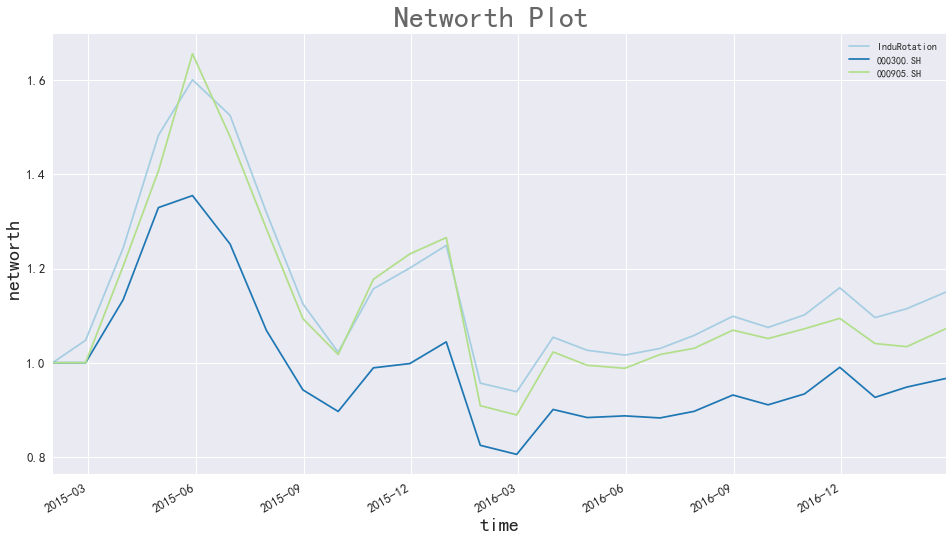

In [164]:
networth.loc[induRankdf.index[0]] = 1
networth = networth.sort_index()
fig = plt.figure(figsize=(14, 9))
# Add a subplot
ax = fig.add_subplot(111)
networth.plot(figsize=(16, 9), ax=ax, color=sns.color_palette("Paired", 11),
                                             fontsize=13, title='Networth Plot ')
ax.set_title(ax.get_title(), alpha=0.7, fontsize=30)
plt.xlabel('time', fontsize=20)
plt.ylabel('networth ', fontsize=20)
plt.show()

In [70]:
from itertools import product
c= [1,2,3,4]
b = [5,6,7,8]
a= [c,b]
list(product(*a))

[(1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8)]

In [170]:
filename = 'newindex.xlsx'

In [242]:
newIndex = 'newIndex'

In [260]:
filenameAmount = 'LZ_CN_STKA_DERI_AmountAvg_1M.h5'

In [261]:
stkTradeAmount = ff.readh5data(path,filenameAmount)

In [288]:
# 数据预处理
indexData = ff.readh5data(path, filenameIndex)
tradeAmount = ff.readh5data(path, filenameIndexAmount)

windAindex = pd.read_csv(path+filenameWindA, infer_datetime_format=True, parse_dates=[0], index_col=0).CLOSE
windAindex.name = windA
windAAmount = pd.read_csv(path+filenameWindA, infer_datetime_format=True, parse_dates=[0], index_col=0).AMOUNT
windAAmount.name = windA

indexData = pd.concat([windAindex, indexData], axis=1)
tradeAmount = pd.concat([windAAmount, tradeAmount], axis=1)

In [289]:
xls = pd.ExcelFile(path+filename)
df1 = xls.parse(u'股票代码',header=None,index_col=0,parse_dates=True)
df1.index.name = 'time'
df1 = df1.applymap(lambda x: str(x)[1:-1])
df2 = xls.parse(u'不加手续费', parse_dates=True, index_col=0)
df2.index.name = 'time'
df2 = df2.iloc[:,0]
df2.name = newIndex

In [290]:
dateCountList = df1.index.tolist()

In [291]:
startTime = df1.index[0]
endTime = df1.index[-1]
indexData = indexData.loc[startTime:endTime]
indexData = pd.concat([df2, indexData], axis=1)

In [292]:
stkTradeAmount = ff.readh5data(path,filenameAmount).loc[startTime:endTime]

In [293]:
amountDict = {}
for date in stkTradeAmount.index:
    if date in dateCountList:
        memberList = df1.loc[date].tolist()
    amountDict[date] = (stkTradeAmount.loc[date][memberList].sum())

In [294]:
amountSeries = pd.Series(amountDict)
amountSeries.name = newIndex

In [295]:
tradeAmount = pd.concat([amountSeries, tradeAmount], axis=1).loc[startTime:endTime]

In [297]:
tradeAmount.tail()

,newIndex,881001,000001.SH,801010.SI,801020.SI,801030.SI,801040.SI,801050.SI,801080.SI,801110.SI,...,CI005020.WI,CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI
2017-09-28,7.762603e+06,4.410150e+11,181955627.4,7080300.0,10808770.0,34811740.0,8718750.0,37003620.0,47054850.0,7608460.0,...,6.758489e+06,8.571350e+06,1.371769e+07,1.731809e+07,7.354945e+06,4.854005e+07,3.493563e+07,2.414716e+07,8.324467e+06,4729800.287
2017-09-29,7.545610e+06,4.339110e+11,175892823.0,6064600.0,9366190.0,33936720.0,7395920.0,37470770.0,45702990.0,7178550.0,...,5.672176e+06,7.739908e+06,2.054574e+07,1.412775e+07,6.991915e+06,4.661274e+07,3.859035e+07,2.049998e+07,8.040220e+06,4417178.795
2017-10-09,7.372535e+06,5.376100e+11,227440593.9,9155120.0,9313420.0,36031450.0,7746240.0,35076180.0,58474770.0,14455000.0,...,8.724799e+06,2.183815e+07,2.691933e+07,1.851215e+07,9.964459e+06,5.892082e+07,4.761769e+07,3.048097e+07,1.145155e+07,5500101.418
2017-10-10,6.988601e+06,5.417640e+11,231148615.1,10222970.0,9936380.0,35958380.0,9735610.0,34719980.0,50936720.0,14641400.0,...,9.818089e+06,1.403943e+07,2.591603e+07,1.552316e+07,1.141169e+07,5.059146e+07,3.966814e+07,3.589341e+07,1.515554e+07,5634532.437
2017-10-11,7.063969e+06,5.678810e+11,231154505.9,11941350.0,8698970.0,40636140.0,8049540.0,41543200.0,52574140.0,14837120.0,...,1.116913e+07,1.112976e+07,1.861239e+07,1.594268e+07,1.407812e+07,5.009129e+07,3.421581e+07,3.500643e+07,1.636018e+07,6606094.275


In [299]:
newIndexRank = pd.DataFrame(index=df1.index,columns =['score'],dtype=float)

In [300]:
indexData.tail()

,newIndex,881001,000001.SH,801010.SI,801020.SI,801030.SI,801040.SI,801050.SI,801080.SI,801110.SI,...,CI005020.WI,CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI
2017-10-25,3.018533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-26,3.040512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-27,2.989634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-30,2.914882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-31,2.893285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [301]:
start =time.time()
for date in df1.index[1:]:
    print date
    previousdate = dateCountList[dateCountList.index(date) -1]
    indumember = df1.loc[date].tolist()
    windAmember= windAmember1.loc[date].dropna().index.tolist()
    indicators = getIndexIndicators(newIndex, indumember, windA, [previousdate,date], '2015', indexData, tradeAmount)
    windAIndicators = getIndexIndicators(windA, windAmember, windA, [previousdate,date], '2015', indexData, tradeAmount)
    score = calTotalScore(indicators, windAIndicators, weightList)
    newIndexRank .loc[date] = score
print '%s seconds elapsed' % (time.time() - start)

2012-02-08 00:00:00
2012-03-07 00:00:00
2012-04-09 00:00:00
2012-05-09 00:00:00
2012-06-06 00:00:00
2012-07-05 00:00:00
2012-08-02 00:00:00


c:\python27\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in less_equal


2012-08-30 00:00:00
2012-09-27 00:00:00
2012-11-01 00:00:00
2012-11-29 00:00:00
2012-12-27 00:00:00
2013-01-29 00:00:00
2013-03-05 00:00:00
2013-04-02 00:00:00
2013-05-07 00:00:00
2013-06-04 00:00:00
2013-07-05 00:00:00
2013-08-02 00:00:00
2013-08-30 00:00:00
2013-10-08 00:00:00
2013-11-05 00:00:00
2013-12-03 00:00:00
2013-12-31 00:00:00
2014-01-29 00:00:00
2014-03-05 00:00:00
2014-04-02 00:00:00
2014-05-05 00:00:00
2014-06-03 00:00:00
2014-07-01 00:00:00
2014-07-29 00:00:00
2014-08-26 00:00:00
2014-09-24 00:00:00
2014-10-29 00:00:00
2014-11-26 00:00:00
2014-12-24 00:00:00
2015-01-23 00:00:00
2015-02-27 00:00:00
2015-03-27 00:00:00
2015-04-27 00:00:00
2015-05-26 00:00:00
2015-06-24 00:00:00
2015-07-22 00:00:00
2015-08-19 00:00:00
2015-09-18 00:00:00
2015-10-23 00:00:00
2015-11-20 00:00:00
2015-12-18 00:00:00
2016-01-18 00:00:00
2016-02-22 00:00:00
2016-03-21 00:00:00
2016-04-19 00:00:00
2016-05-18 00:00:00
2016-06-17 00:00:00
2016-07-15 00:00:00
2016-08-12 00:00:00
2016-09-09 00:00:00


In [302]:
newIndexRank

,score
time,
2012-01-04,NaN
2012-02-08,0.58
2012-03-07,0.98
2012-04-09,0.68
2012-05-09,0.78
2012-06-06,0.34
2012-07-05,0.58
2012-08-02,0.68
2012-08-30,0.52


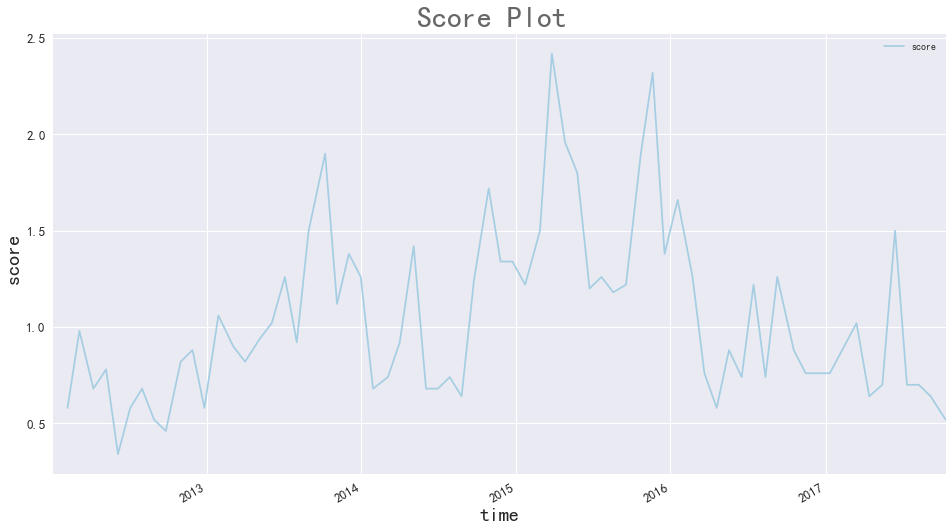

In [303]:
fig = plt.figure(figsize=(14, 9))
# Add a subplot
ax = fig.add_subplot(111)
newIndexRank.plot(figsize=(16, 9), ax=ax, color=sns.color_palette("Paired", 11),
              fontsize=13, title='Score Plot ')
ax.set_title(ax.get_title(), alpha=0.7, fontsize=30)
plt.xlabel('time', fontsize=20)
plt.ylabel('score ', fontsize=20)

In [306]:
import os
path = os.path.abspath(os.path.dirname(__file__))

NameError: name '__file__' is not defined